# Rainbow

An IPython Notebook exploring rainbows using water-droplet geometry.

If you are interested in the punchline without all the intermediate steps: Scroll to the bottom, very last section. On the other hand you can persevere from here onward to experience a semblance of drama... do rainbows really exist???


## Part 0 Assumptions

Let's build a conceptual picture of a rainbow using simple ideas chained together. First I will set these out in a very minimal way. Then I re-state them in a more elaborate 'you are there' sense. The ideas is then to translate the ideas into practice as Python code including plots and figures. If this all works we might build a convincing case for rainbows to exist. 

#### Simple statement of assumptions

* Light of all colors arrives from the sun, a distant point source, as parallel rays, each light particle having a physical trajectory and an associated color (wavelength).  
* These light particles (photons) scatter backwards from a cloud of spherical water droplets in the air.
* Scattering geometry is based on the normal to the droplet surface at the point of photon arrival per Snell's law. 
* In particular the backscattered light follows a Snell refraction into the droplet, then an internal reflection at the back of the droplet, then another refraction as it leaves the droplet. That's the trajectory we wish to map.
* Does a uniform distribution of photons impinging on a distribution of droplets produce the sensation of a coherent rainbow in the eye of a person looking toward the droplets and away from the sun? Of course it does; but do these assumptions produce that result?

#### Detailed statement of assumptions

* Rainbows are formed from the backscatter of light incident on water droplets suspended in air. The water droplets may be falling fast (like rain) but they may be very small -- like mist -- and therefore they may fall slowly. 
* Where is the light coming from? Light arrives from the sun at a low angle relative to the horizon, as in 'over your shoulder'. It is difficult to see rainbows at noon with the sun high overhead. 
* To see a rainbow you look directly away from the sun. The light particles (photons) coming over your shoulder hit water droplets suspended in the air before you. These might be close, as from a garden hose set on 'mist', or they might be far, as in a distant rain cloud. 
* The light reflects from or scatters from the droplets of water and some of this scattered light enters your eye. The pattern of reflected light that you perceive is interpreted by you as arcs of concentric color, a rainbow. Red is on the outside of the bow, blue on the inside.
* Someone standing next to you also sees a rainbow. Does it appear to be in the same location as the one you see?

That's the basic set up. Now I describe a first model for scattering of light by water droplets. It relies on the idea of a normal to a surface so let me say first: A curved surface like a water droplet that is examined at a local point appears flat just as we perceive the earth to be flat where we are standing. The flat surface plane touches the sphere at this local point and it is called the tangent plane. A spike sticking straight up out of this plane at this local point -- like a signpost -- defines the surface-normal direction. In optics when light encounters a boundary such as the air-water boundary of our droplet at this local point: The path of the light bends in a manner described in terms of this surface-normal. Again: The tangent plane at the local point is perpendicular to the line from the center of the sphere to the local point which coincides with the surface-normal direction.

* We assume water droplets are small so surface tension pulls them into a spherical shape. They are suspended in the air and move slowly enough that we consider them to be holding still.
* Light enters each water droplet in a spatially even distribution of parallel rays as if from an infinitely distant point source. We ignore that the sun has a width of about half of a degree. This is one of several details in the assumptions where we could come back and say 'wait a second... what about the width of the sun?'
* Light entering the water droplet obeys Snell's law, traveling in a plane defined by two vectors: The incident velocity vector and the vector normal to the sphere at the point of incidence. This plane passes through the center of the droplet sphere. 
    * Snell's law therefore gives us the important result that each photon travels in a circular disc that bisects the water droplet. This simplifies our problem because we can work in two dimensions, in an arbitrary plane of bisection; and then after that we can extend the results to the fact that these planes can be oriented at any angle around the line from the sun to the droplet. I refer to this as the azimuthal angle about the sun-droplet axis.
* This is a relative distribution problem: Given a bunch of sunlight where do the light particles tend to go? The water drops are distributed in a sheet at random and act to scatter only the light that hits them; so they are independent of one another.  Further the photons point-particles. Consequently the radius of the droplets is immaterial and is taken to be 1. The number of photons is very large. The code below does not need to try and use actual photon counts or droplet sizes. 'Lots of photons' and 'radius = 1' will do. 
* The idea is to consider the scattering of light for a single droplet and then eventually to explore the effect of many such scatterers.

Finally (whew this is taking a lot of words!) we want to consider the scattering path of the photon in detail. That's what everything depends on. 

* While many incident light particles scatter off the droplet, and while many more will pass through the back of the droplet, we are concerned only with backscatter and therefore only the following trajectory: 
    * The incident light particle (photon) enters the droplet
        * Its path bends on entry per Snell's law
    * The photon reflects off the back of the droplet thereby staying inside the droplet
        * Its path obeys angle of incidence = angle of reflection off the plane tangent to the droplet surface
    * The photon impinges a second time on the surface of the droplet, this time passing through it
        * Undergoing another path bend per Snell's law
* We make the problem two dimensional as noted, considering one particular plane bisecting the water droplet sphere; so we are working with the unit circle. 
* We take a uniform distribution of incident particles arriving at the first quadrant of that unit circle from y = 0 (aligned with the center of the droplet) to y = 1 grazing the top of the droplet. The particles from y = 0 to y = -1 are just a reflection so let's not worry about them. 
* Each particle is initially traveling with no y-component to its velocity: It simply comes in from the far right on a path exactly parallel to the x-axis.

Finally when all is said and done we may ask: If we throw a million photons at the water droplet each separated by one millionth in the y direction: At what angle will they be ejected by the droplet? Do they go all over the place or is there perhaps a preferred direction of scattering? If the latter then the water droplet would be acting as a light-focusing mechanism; which sort of stands to reason because the water droplet is curved a bit like a lens.

## Part 1 Droplet Scattering

In [1]:
# make plots exist inline (not pop-out) and get the numpy and pyplot libraries in place. And make pi easier to write.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

pi = np.pi

In [2]:
# This dispersion relation is a simple linear interpolation between red and violet values; approximately correct
def indexOfRefractionForWater(wavelength):
    if (wavelength < 400.0): return
    if (wavelength > 700.0): return
    ind400 = 1.339
    ind700 = 1.331
    deltaind = ind700 - ind400
    deltawavefraction = (wavelength - 400.0)/300.0
    return (deltaind * deltawavefraction) + ind400


In [3]:
# generic binning to histogram
def getbin(value, lo, hi, bins):
    if (value <= lo): return 0
    if (value >= hi): return bins-1
    bin = int((value-lo)*(bins/(hi - lo)))
    if (bin >= 0 and bin < bins):
        return bin

In [4]:
# Snell's law generalization to incident and transmission media
def snell(angleInc, indexInc, indexTrans):
    return np.arcsin((indexInc/indexTrans)*np.sin(angleInc))

In [5]:
# you just know this already exists
def rtd(angleRadians): return angleRadians*180.0/pi

In [6]:
# you just know this already exists
def dtr(angleDegrees): return angleDegrees*pi/180.0

In [7]:
def scatter(y, wavelength, iorAir, iorWater):
    alpha = np.arcsin(y)          # alpha is the angle of incidence
    beta = snell(alpha, iorAir, iorWater)   
    return 4.*beta - 2.*alpha

In [8]:
def scatterWithFresnel(y, wavelength):
    iorAir = 1.00029
    iorWater = indexOfRefractionForWater(wavelength)
    alpha = np.arcsin(y)          # alpha is the angle of incidence
    beta = snell(alpha, iorAir, iorWater)   
    T1 = 1.0 - RCoefficient(alpha, iorAir, iorWater)
    R1 = RCoefficient(beta, iorWater, iorAir)
    T2 = 1.0 - R1 # Since beta is found at both Q and R
    return T1, R1, T2, 4.*beta - 2.*alpha

In [9]:
def RCoefficient(angle, n1, n2):
    sineTerm = (n1/n2)*np.sin(angle)
    radArg = 1 - sineTerm*sineTerm
    radical = np.sqrt(radArg)
    RsNum = n1*np.cos(angle) - n2*radical
    RsDenom = n1*np.cos(angle) + n2*radical
    RpNum = n1*radical - n2*np.cos(angle)
    RpDenom = n1*radical + n2*np.cos(angle)
    Rs = (RsNum * RsNum) / (RsDenom * RsDenom)
    Rp = (RpNum * RpNum) / (RpDenom * RpDenom)
    return (Rs+Rp)/2.0

In [10]:
# This cell is configuration steps prior to the next cell running

# To keep track of where the light goes (scattering angle) we create a list of histograms cut into 0.001-radian bins
#   Each histogram will track a particular color as the incoming photons cycle from y = 0 to y = 1
epsilon = 0.001
domainLo = -pi/2.
domainHi = pi/2.
domain = np.arange(domainLo, domainHi, epsilon)
domainBins = domain.shape[0]

domainDeg = domain * 180.0 / pi
print type(domain)

cWaves = [400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0]    # list of color-associated wavelengths of light (nm)
cLabels = ['violet', 'b','cyan','g', 'y', 'orange', 'r']      # color labels for the light
nC = len(cWaves)    # how many colors to consider
# nC = 1     # uncomment this to test code against 'just violet' (faster)

histogram = []          
for i in range(nC):
    histogram.append(np.zeros(domainBins))  # list of histograms accumulated by wavelength/color
print len(histogram)

yIncident = []     # an array of incident y-values (offsets from the droplet-sun line)
alphaDeg = []      # incoming incidence relative to normal
sigmaDeg = []      # scatter angle

for i in range(nC):
    sigmaDeg.append([])  # a List of outputs accumulated by wavelength

<type 'numpy.ndarray'>
7


In [11]:
# This cell fires one million photons at the droplet nC (number-of-colors) times and tracks where they come out

maxSigma = -2.*pi
yOfMaxSigma = 0.0
firstY = 0.0
lastY = 1.0
intervalY = 0.000001

# preceding the color loop we bookkeep information that applies to all colors across the y-coordinate scan
for yP in np.arange(firstY, lastY, intervalY):
    # alpha is local incidence, common to all colors
    yIncident.append(yP)
    alpha = np.arcsin(yP)          # alpha is the angle of incidence
    alphaDeg.append(rtd(alpha))    # include 'degrees' for familiarity

# loop index i over all colors of interest ('ROYGBIV')
for i in range(nC):

    wavelength = cWaves[i]

    # index of refraction of water depends on wavelength
    # this prismatic effect is called 'dispersion of light'
    iorWater = indexOfRefractionForWater(wavelength)

    # index of refraction for air is taken as wavelength-independent
    iorAir = 1.00029

    x = 1000.0            # technically should be about 93 million miles (but we don't use this value)

    for yP in np.arange(firstY, lastY, intervalY):

        # Refer to the diagram above for some of these labels:
        #   (x, y) is a point of origin off towards the sun
        #   (xP, yP) is where the incident photon strikes the droplet at point P
        #   C is the center of the droplet (the origin) in this coordinate system
        #   U (for _Unity_) is the point at (1, 0), a convenient reference point
        #   Q is the point of photon reflection at the back edge of the droplet
        #   R is the point where the photon emerges from the droplet back into the air       
        # P = (xP, yP)
        # Not used: xP = np.sqrt(1.0-yP*yP) # positive square root puts P in the first quadrant


        # beta is the internal refracted angle relative to the unit normal at P
        # beta = snell(alpha, iorAir, iorWater)
        
        # sigma = 4.*beta - 2.*alpha
        # Notice we do not use 'scatterWithFresnel' so the result is unweighted: 1 photon
        sigma = scatter(yP, wavelength, iorAir, iorWater)
        
        # The subsequent code here is commented out. It concerns 'following the photon' through 
        # the droplet which is revisited in subsequent sections when we consider attenuation.
        # 
        # WARNING: The following code has not been tested; just written up in comments. (kilroy)
        #
        # beta is the refracted angle: Bending in towards the normal line at point P
        # the deflected photon next strikes the back wall of the droplet at point Q
        # angleQCP is from triangle QCP being isosceles
        # angleQCP = pi - 2*beta
        #
        # angleQCU is relative to the +x axis, the line from droplet to sun
        # angleQCU = angleQCP + alpha
        #
        # Q = (xQ, yQ)
        # xQ = np.cos(angleQCU)
        # yQ = np.sin(angleQCU)
        #
        # The light reflects at Q using angle(incidence) = angle(reflection)
        # It will next strike the surface of the droplet at point R
        # angleQCR = angleQCP             # again using isosceles arguments
        #
        # angleRCU measures positive from RC clockwise to UC
        # angleRCU = angleQCR + angleQCU
        #
        # R = (xR, yR)
        # xR = np.cos(angleRCU)
        # yR = np.sin(angleRCU)
        # 
        # angleUCR is positive measured from UC clockwise to CR 
        # This angle is the angle of the normal at R
        # angleUCR = 2*pi - angleRCU
        #
        # The rays will emerge at R in some direction to intersect an outer circle of radius 'large'. 
        # S = the emergent ray's point of intersection with the outer circle = (xS, yS)
        # 
        # gamma is the refraction angle at R
        # gamma = snell(beta, iorWater, iorAir)
        #
        # sigma is the scatter angle from the droplet, calculated above. It can be calculated directly
        #   here by subtracting gamma from angleUCR. The result will be positive or zero.
        # sigma_version2 = angleUCR - gamma
        #
        # sigma_version2 will differ from sigma by a very small amount due to floating point precision

        if sigma > maxSigma:
            maxSigma = sigma
            yOfMaxSigma = yP
            
        sigmaDeg[i].append(rtd(sigma))
        binNumber = getbin(sigma, domainLo, domainHi, domainBins)

        # I include Transmission and Reflection and Transmission coefficients to anticipate calculating
        #   them more carefully down below in this notebook.
    
        if binNumber >= 0 and binNumber < domainBins: histogram[i][binNumber] += 1

print len(sigmaDeg[0])
print len(yIncident)
print 'Carry on, Sergeant Major!'

1000000
1000000
Carry on, Sergeant Major!


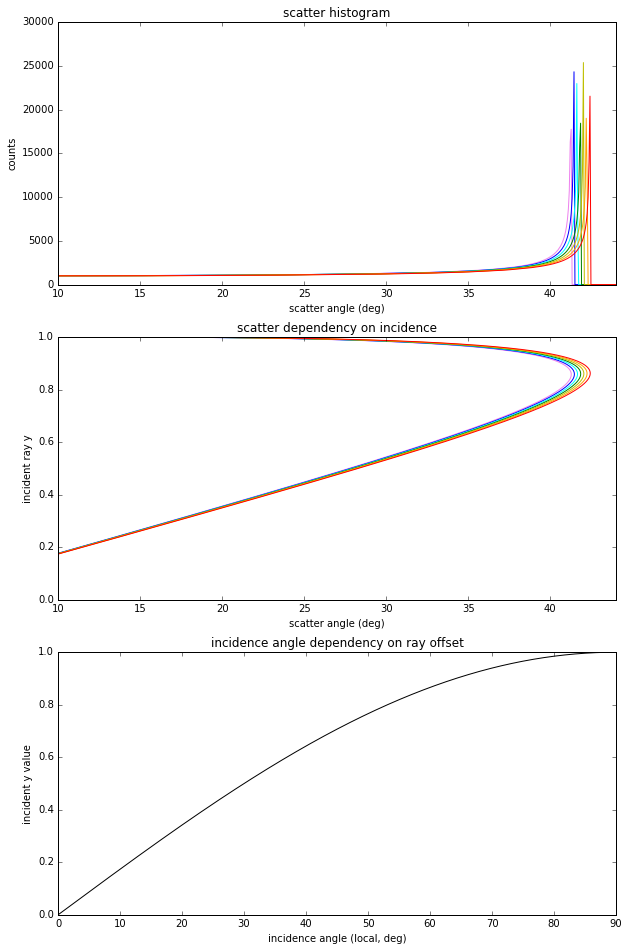

In [12]:
# This cell creates a stack of three plots: histogram of scatter angles, 
# scatter as function of incidence, and the range of incidence angles.

# plt.subplots returns a tuple: A general-context figure and a list of sub-plots assigned to axes
fig, axes = plt.subplots(3, figsize=(10,16))
axisHistogram = axes[0]    # I break the axes list apart into more identifiable names
axisScatter   = axes[1]
axisIncidence = axes[2]

for i in range(nC):
    axisHistogram.plot(domainDeg, histogram[i], cLabels[i])
    axisScatter.plot(sigmaDeg[i], yIncident, cLabels[i])

axisIncidence.plot(alphaDeg, yIncident, 'k')

axisHistogram.set(xlim=(10.0, 44.0))
axisHistogram.set(xlabel='scatter angle (deg)', ylabel = 'counts', title='scatter histogram')

axisScatter.set(xlim=(10.0, 44.0))
axisScatter.set(ylabel='incident ray y', xlabel = 'scatter angle (deg)', title='scatter dependency on incidence')

axisIncidence.set(xlim=(0.0, 90.0),ylim=(0.0,1.0))
axisIncidence.set(ylabel='incident y value', xlabel = 'incidence angle (local, deg)', \
                  title='incidence angle dependency on ray offset')

__Caption__ The top figure shows that a disproportionate number of photons emerge at an angle of 41 to 42 degrees or so. The water droplet focuses the light into these angles which vary a bit with wavelength. The center figure shows that these spikes are due to a range of incident y-values from about y = .75 to y = .9. That range gives the concentration shown by the spikes in the first figure. The third figure shows that the y value of the incident light maps into incidence angle fairly linearly for y on [0.0, 0.6] and then starts to curve for larger values of y, reaching incidence angles of 70 degrees or higher for y on [0.9, 1.0]. This information is used in a later section that accounts for all the incident light, not just the photons that follow our recipe of transmit-reflect-transmit.  

In [31]:
redIndex = nC-1
violetIndex = 0
maxRedIndex = np.where(histogram[redIndex] == histogram[redIndex].max())[0][0]
maxVioletIndex = np.where(histogram[violetIndex] == histogram[violetIndex].max())[0][0]

redMaxAngleDegrees = rtd(domain[maxRedIndex])
violetMaxAngleDegrees = rtd(domain[maxVioletIndex])

redMAD2 = round(redMaxAngleDegrees, 2)
violetMAD2 = round(violetMaxAngleDegrees, 2)
print 'red max histogram angle:', redMAD2, 'deg'
print 'violet max histogram angle:', violetMAD2, 'deg'
print 'Wikipedia rainbow is 42.00 - 40.89 =', 42.00 - 40.89, 'degrees wide'
print 'This rainbow is', redMAD2, '-', violetMAD2, '=', \
    round(redMaxAngleDegrees - violetMaxAngleDegrees, 2), 'degrees wide'

# 40.89 to 42 (red) is 1.11 degrees (Wikipedia article on rainbows)
# My rainbow is 1.146 degrees wide


red max histogram angle: 42.41 deg
violet max histogram angle: 41.26 deg
Wikipedia rainbow is 42.00 - 40.89 = 1.11 degrees wide
This rainbow is 42.41 - 41.26 = 1.15 degrees wide


## Part 2. Photon trajectory tracer

Now that we have shown an emphasized scattering direction... which is just the starting point of a convincing argument unless you like jumping to conclusions... it is time to look at what happens to the individual particles as they are incident on the water droplet. 

For wavelength 400 nm the max eject angle is 41.19 at incidence y = 0.84
For wavelength 700 nm the max eject angle is 42.3 at incidence y = 0.84


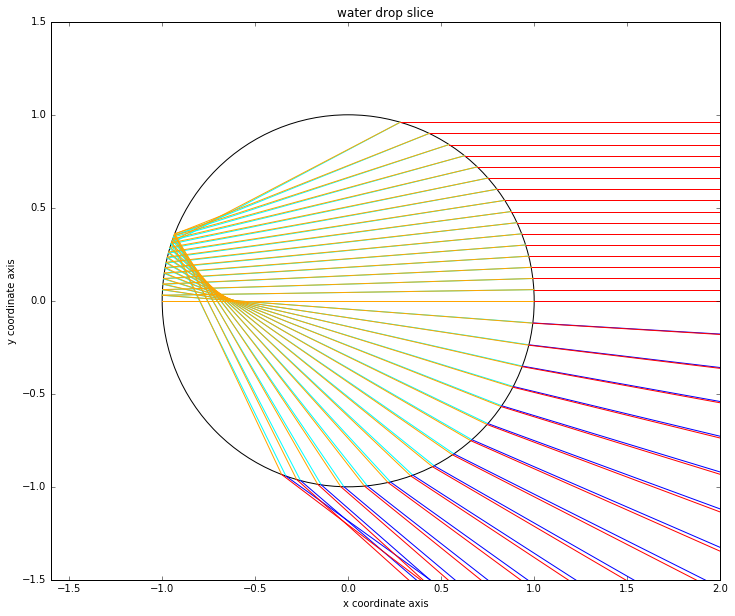

In [14]:
# This cell narrates some more of "what's happening" in graphics rendering and shows a set of incident photon
#   paths through a 2D slice of a water droplet.

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12,10))

# now we say that 'fig' is the overall canvas
# ax is the (list of) axes
# after this we leave fig alone and just use ax
#
# The heirarchy: figure contains a bunch of axes (subplots) and an axis contains a bunch of artists
#
# How can we make the figure larger? Here are some constructions where 'plt' is 'matplotlib.pyplot'.
# fig.set_figure()
# plt.figure(figsize=(12,12))
# fig = plt.figure(figsize=(12,10))

# a patch is a filled shape
# from matplotlib import patches
# patches.<tab> shows you them
# This circle patch is not filled
ax.add_patch(plt.Circle((0, 0), 1, color = 'k', fill=False))

# Drawing a (not very) distant circle as the proxy for many observing eyes.
# That is, I needed a definite locus of points to act as endpoints for the ejected
#   photons; so I chose a circle of radius 2, just twice that of the unit circle 
#   used for the droplet. 
radiusCircleAtInf = 2.0
# ax.add_patch(plt.Circle((0, 0), radiusCircleAtInf, color = 'k', fill=False))

# unity aspect ratio
ax.axis('equal')

# How To note...
# ax.set_xlim(-7, 7)
# ax.set_ylim(-7, 7)

ax.set(xlim=(-1.1, 1.5), ylim=(-1.5,1.5))
ax.set(xlabel='x coordinate axis', ylabel = 'y coordinate axis', title='water drop slice')

maxEject = -pi
maxIncidentY = 0.0

colorScheme = 0
colorSelect = [
    [['blue','cyan','cyan','blue'],['red','orange','orange','red']], 
    [['blue','cyan','green','black'],['none','none','none','none']], 
    [['none','none','none','none'],['red','orange','orange','red']]  
    ]

for w in range(2):

    wavelength = 400 + 300*w

    # indices of refraction
    iorWater = indexOfRefractionForWater(wavelength)
    iorAir = indAir = 1.00029

    yInterval = 0.06

    # The commented out version separates red and blue incident rays visually
    # for y0 in np.arange(w*yInterval/2., 1.0, yInterval):
    for y0 in np.arange(0.0, 1.0, yInterval):
    
        # (x0, y0) is the point off at + infinity where one of the parallel rays comes in from
        x0 = 3.0

        # (x, y) is the point at which a ray intersects the surface of the droplet (radius = 1)
        # Call this point P
        # Call the center of the circle/sphere point C
        # Call (1, 0) the point U (for Unit). It is a convenient reference point.
        y = y0
        x  = np.sqrt(1.0-y*y)

        # here is our incident ray
        ax.plot([x0, x], [y, y], color=colorSelect[colorScheme][w][0])

        # Take out the radial lines to reduce clutter
        # ax.plot([0.0, x], [0.0, y], color='g')

        # incidenceAngle1 is measured relative to the circle (sphere) normal at (x, y)
        incidenceAngle1 = np.arctan2(y, x)

        # angleWater is the refracted angle: Bending in towards the normal line
        angleWater = snell(incidenceAngle1, iorAir, iorWater)
    
        # the ray will deflect and strike the far wall of the droplet at point Q
        # internal1 = angle QCP (a positive value; from isoscelesiness)
        internal1 = pi - 2*angleWater

        # internalTotal1 = angle QCU
        internalTotal1 = internal1 + incidenceAngle1

        # Q = (x2, y2)
        x2 = np.cos(internalTotal1)
        y2 = np.sin(internalTotal1)

        # Now draw the first leg of the journey inside the water drop
        ax.plot([x2, x], [y2, y], color=colorSelect[colorScheme][w][1])

        # The light reflects at Q using angle(incidence) = angle(reflection)
        # It will strike the surface of the droplet at point R
        # internal2 = angle QCR
        internal2 = pi - 2*angleWater              # the same as internal1!

        # internalTotal2 = RCU measured as positive from R clockwise to U
        internalTotal2 = internalTotal1 + internal2

        # R = (x3, y3)
        x3 = np.cos(internalTotal2)
        y3 = np.sin(internalTotal2)

        # Draw the second part of the path through the drop
        ax.plot([x2, x3], [y2, y3], color=colorSelect[colorScheme][w][2])
        # print rtd(angleWater)

        # externalTotal is the angle UCR measured from U clockwise to R 
        # It is 'external' because this angle is the angle of the normal at R
        externalTotal = 2*pi - internalTotal2

        # The rays will escape in some direction and intersect an outer circle of radius 'large'. 
        # S = the emergent ray's point of intersection with the outer circle = (x4, y4)

        # incidenceAngle2 = the incidence angle at R relative to the normal
        incidenceAngle2 = (pi - internal2)/2.

        # external = the transmission angle at R relative to the normal
        external = snell(incidenceAngle2, iorWater, iorAir)

        # ejectAngle is the angle at which the ray is ejected from the drop
        #   measured relative to the +x-axis direction. It will tend to be
        #   sign-changed in subsequent calculations; that is under the conditions
        #   established here it is technically negative. Soi sage.
        ejectAngle = externalTotal - external

        if ejectAngle > maxEject:
            maxEject = ejectAngle
            maxIncidentY = y0

        # Now we have triangle CRS from the center to the eject point R to the intersection
        #   of the ejected ray with Circle(radius 2) at point S. We need the coordinates of 
        #   S now. We could use a very large circle centered on R as an approximation for a
        #   very large circle centered at the origin C...
        radiusLarge = 1000.0
        x4 = radiusLarge * np.cos(-ejectAngle)
        y4 = radiusLarge * np.sin(-ejectAngle)
        ax.plot([x3, x4], [y3, y4], color=colorSelect[colorScheme][w][3])

    print 'For wavelength', wavelength, 'nm the max eject angle is',\
        round(rtd(maxEject),2), 'at incidence y =', maxIncidentY


__Caption__ This figure shows light particle paths that follow our refract-reflect-refract recipe. Recall that photons with a y value close to 1.0 do not contribute to the 'spike' (Figure 1, top and middle). Since the view here emphasizes the photon path inside the water droplet it misses the big picture of 'where does the light tend to go?' For that view we produce a new figure where the droplet is scaled down to _dot_ size.

## Part 3. Droplet from a distance

Let's draw the same diagram as above with two changes. First we'll make the scale of the diagram much larger so that the drop diminishes to a point scatterer. Second let's figure out a way of indicating the histogram: Where most of the light goes in relation to other directions.



For wavelength 400 nm the max eject angle is 41.27 at incidence y = 0.8575
For wavelength 700 nm the max eject angle is 42.43 at incidence y = 0.8625
Black line shows mean of red and violet max-count photon eject angles =  41.85


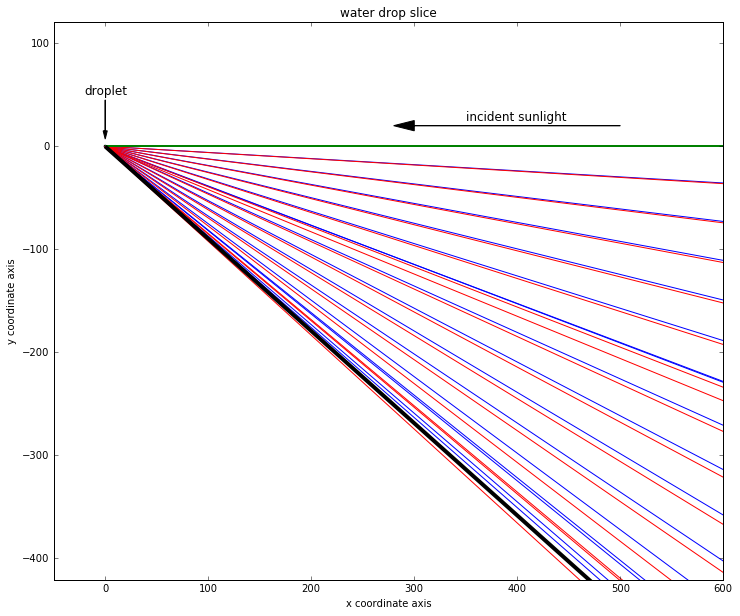

In [32]:
# This cell is a slimmed-down version of the previous Python cell: A set of incident photon
#   paths through a 2D slice of a water droplet but seen at a distance.

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12,10))
ax.add_patch(plt.Circle((0, 0), 1, color = 'k', fill=False)) 
radiusCircleAtInf = 200.0
ax.axis('equal')

ax.set(xlim=(-50, 600.), ylim=(-400,100))
ax.set(xlabel='x coordinate axis', ylabel = 'y coordinate axis', title='water drop slice')

maxEject = -pi
maxIncidentY = 0.0

colorScheme = 0
colorSelect = [
    [['none','none','none','blue'],['green','none','none','red']], 
    [['blue','none','none','blue'],['none','none','none','none']], 
    [['none','none','none','none'],['red','none','none','red']]  
    ]

averageMaxEjectAngle = 0.0
numWavelengths = 2

for w in range(numWavelengths):

    wavelength = 400 + 300*w

    iorWater = indexOfRefractionForWater(wavelength)
    iorAir = indAir = 1.00029
    yInterval = 0.0025
    modCount = 0
    modDrawTrajectory = 25

    for y0 in np.arange(0.0, 1.0, yInterval):
        x0 = 1000.0
        y  = y0
        x  = np.sqrt(1.0-y*y)
        modCount += 1

        # here is our incident ray
        incidenceAngle1 = np.arctan2(y, x)
        angleWater = snell(incidenceAngle1, iorAir, iorWater)
        internal1 = pi - 2*angleWater
        internalTotal1 = internal1 + incidenceAngle1
        x2 = np.cos(internalTotal1)
        y2 = np.sin(internalTotal1)
        internal2 = pi - 2*angleWater              # the same as internal1!
        internalTotal2 = internalTotal1 + internal2
        x3 = np.cos(internalTotal2)
        y3 = np.sin(internalTotal2)
        externalTotal = 2*pi - internalTotal2
        incidenceAngle2 = (pi - internal2)/2.
        external = snell(incidenceAngle2, iorWater, iorAir)
        ejectAngle = externalTotal - external
        if ejectAngle > maxEject:
            maxEject = ejectAngle
            maxIncidentY = y0
        radiusLarge = 1000.0
        x4 = radiusLarge * np.cos(-ejectAngle)
        y4 = radiusLarge * np.sin(-ejectAngle)

        if modCount % modDrawTrajectory == 0:
            ax.plot([x0, x], [y, y], color=colorSelect[colorScheme][w][0])
            ax.plot([x2, x], [y2, y], color=colorSelect[colorScheme][w][1])
            ax.plot([x2, x3], [y2, y3], color=colorSelect[colorScheme][w][2])
            ax.plot([x3, x4], [y3, y4], color=colorSelect[colorScheme][w][3])

    print 'For wavelength', wavelength, 'nm the max eject angle is',\
        round(rtd(maxEject),2), 'at incidence y =', maxIncidentY
    
    averageMaxEjectAngle += maxEject

averageMaxEjectAngle /= numWavelengths
print 'Black line shows mean of red and violet max-count photon eject angles = ', round(rtd(averageMaxEjectAngle), 2)

# point of origin slightly away from the origin towards scatter direction for a cleaner plot
x0 = np.sqrt(2.0);
y0 = -np.sqrt(2.0); 

x1 = 10000.0 * np.cos(-averageMaxEjectAngle)
y1 = 10000.0 * np.sin(-averageMaxEjectAngle)
ax.plot([x0, x1], [y0, y1], color='black', linewidth='4')

# For arrow note see https://philbull.wordpress.com/2012/04/05/drawing-arrows-in-matplotlib/ (DEI!)
ax.arrow( 500., 20., -200., 0., fc='k', ec='k', head_width=10.0, head_length=20.0 )

# include some text annotation
ax.text( 350, 25, 'incident sunlight', fontsize=12)
ax.text( -20, 50, 'droplet', fontsize=12)
ax.arrow(0., 45., 0., -30., fc='k', ec='k', head_width = 4., head_length = 8.)
 


__Caption__ This is the same diagram as previous but at a much smaller scale (bigger space) so the droplet has shrunk to a point. We only show red and blue light here. Incoming light is colored green for 'both'. Scatter angles (sigma) for red and blue light can be seen to slightly diverge at larger angles. The average of the red and blue maxima is shown as a heavy black line: The direction where incident sunlight is concentrated.

## Part 4. Fresnel has a say

There are two important extensions of the basic geometry given above. First we should account for relative outcomes for the photons based on where on the sphere's curved surface they strike. Some may follow our 'refract-bounce-refract' trajectory but other photons may do something else. Second we should account for an even distribution of photons across a plane perpendicular to the sunlight axis. That is: To this point we have been working with slices through the droplet; but in fact many such slices come into play (like orange slices) because the droplet is three-dimensional. 

In this section we use the Fresnel equations to more accurately see what the photon scatter distribution is like, still working with a slice and a set of incident photons evenly distributed between y = 0 and y = 1 for a unit-circle droplet. 


Fresnel equations work from the premise that the photon/drop-boundary interaction is probabilistic: There are probabilities for the photon's future for transmission, reflection, scattering and absorption; and even this is a simplification of the full physics. I constrain the discussion to _'either reflect or transmit'_ now in order to  explore the problem of rainbows in a bit more depth:

* Does the reflect / transmit probability vary with angle; which could change our intensity distribution that appeared very conveniently up above (answer: Yes it does!)
* Does the reflect / transmit probability give a story for secondary, tertiary etc rainbows? (answer: Again yes; but I'm not going to track those other paths in this section.)

The rule for transmit-versus-reflect is expounded (to a degree) by Wikipedia of course, under the topic of Fresnel equations: https://en.wikipedia.org/wiki/Fresnel_equations.

Interestingly for a particular wavelength we could use red and blue lasers together with a suitable light sensor to measure light reflection as a function of angle. This would be an interesting experiment although perhaps it would be wise to combine it with other material in a lab... not everyone gets excited about demonstrating something that is already well known! 

In [16]:
# This cell is a re-paste of the config cell above, compressed down

histogram = []          
for i in range(nC):
    histogram.append(np.zeros(domainBins))  # list of histograms accumulated by wavelength/color
print len(histogram)

yIncident = []     # an array of incident y-values (offsets from the droplet-sun line)
alphaDeg = []      # incoming incidence relative to normal
sigmaDeg = []      # scatter angle

for i in range(nC):
    sigmaDeg.append([])  # a List of outputs accumulated by wavelength

7


In [17]:
# This cell fires one million photons at the droplet nC (number-of-colors) times and tracks where they come out

maxSigma = -2.*pi
yOfMaxSigma = 0.0
firstY = 0.0
lastY = 1.0
# intervalY = 0.000001
intervalY = 0.000001

# preceding the color loop we bookkeep information that applies to all colors across the y-coordinate scan
for yP in np.arange(firstY, lastY, intervalY):
    # alpha is local incidence, common to all colors
    yIncident.append(yP)
    alpha = np.arcsin(yP)          # alpha is the angle of incidence
    alphaDeg.append(rtd(alpha))    # include 'degrees' for familiarity

# loop index i over all colors of interest ('ROYGBIV')
for i in range(nC):
    wavelength = cWaves[i]
    for yP in np.arange(firstY, lastY, intervalY):
        T1, R1, T2, sigma = scatterWithFresnel(yP, wavelength)
        sigmaDeg[i].append(rtd(sigma))
        binNumber = getbin(sigma, domainLo, domainHi, domainBins)
        if binNumber >= 0 and binNumber < domainBins: histogram[i][binNumber] += T1*R1*T2


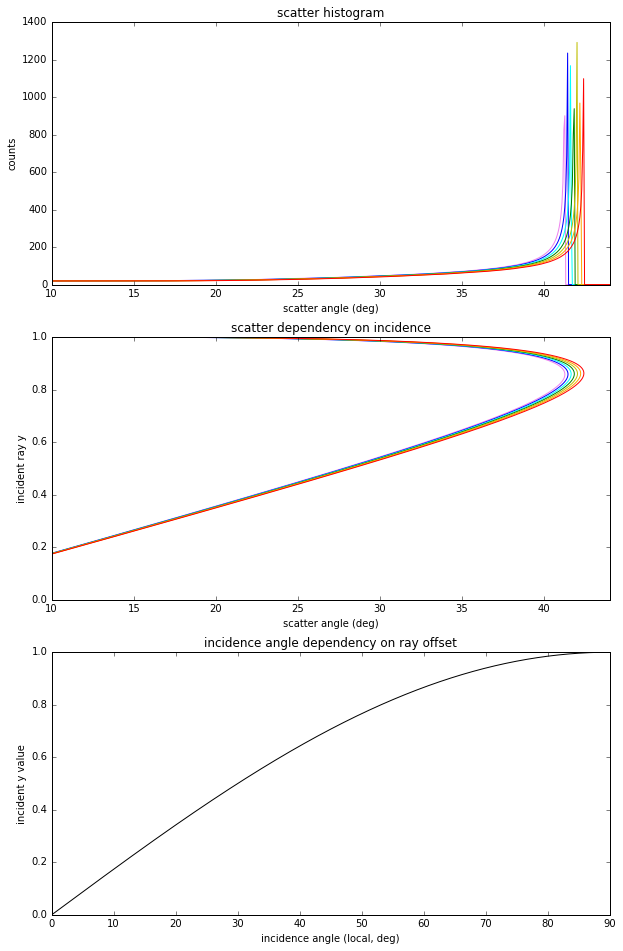

In [18]:
# This cell creates a stack of three plots: histogram of scatter angles, scatter as function of incidence, 
#   and the range of incidence angles.

# plt.subplots returns a tuple: A general-context figure and a list of sub-plots assigned to axes
fig, axes = plt.subplots(3, figsize=(10,16))
axisHistogram = axes[0]    # I break the axes list apart into more identifiable names
axisScatter   = axes[1]
axisIncidence = axes[2]

for i in range(nC):
    axisHistogram.plot(domainDeg, histogram[i], cLabels[i])
    axisScatter.plot(sigmaDeg[i], yIncident, cLabels[i])

axisIncidence.plot(alphaDeg, yIncident, 'k')

axisHistogram.set(xlim=(10.0, 44.0))
axisHistogram.set(xlabel='scatter angle (deg)', ylabel = 'counts', title='scatter histogram')

axisScatter.set(xlim=(10.0, 44.0))
axisScatter.set(ylabel='incident ray y', xlabel = 'scatter angle (deg)', title='scatter dependency on incidence')

axisIncidence.set(xlim=(0.0, 90.0),ylim=(0.0,1.0))
axisIncidence.set(ylabel='incident y value', xlabel = 'incidence angle (local, deg)', \
                  title='incidence angle dependency on ray offset')

## Part 5. Increasing our dimensions by 1

We now have a formalism that I hope is reasonably good for tracking the fate of sunlight relative to a single water droplet slice. The photons arrive in the upper half of the droplet along a 1D line (y = 0 to y = 1) and travel through the 2D slice to depart with preference from the lower half of the droplet.  

To increase our dimensions we want to take a single droplet and illuminate it evenly in space. A simple-minded approach is to paint evenly across a square of side 2 centered on the origin. Some photons will miss but those that hit will be evenly distributed in space across the face of the droplet (which again has a radius of 1). Rather than refer to a y-coordinate in the 1/2-dimensional formulation above we should now refer to the radial coordinate and the angle coordinate for photon arrivals when considered in the plane perpendicular to the sun-droplet axis. 

I can think of two approaches to verifying that evenly-distributed photons will uphold our result so far; so let's first summarize that result.

_Light impinging on the droplet scatters through a fairly even distribution of angles except for a range of radii near the perimeter of the droplet. In this range -- forming an annulus or ring -- the photons will concentrate into a narrow range of angles. This is the meaning of the spikes in the scatter histogram from 41 to 42 degrees. Furthermore these spikes vary with the wavelength of the light. Red light scatters preferentially through a wider angle, and so on._

The first approach I can imagine is to send a lot of photons in to the droplet and create a distribution picture of where they scatter to. Let's save that for the next section, part 6. 

The other approach is to consider that ring of preferential scattering. Some of our even distribution of photons will fall onto the droplet within that narrow range of radial distances. All of these photons at a particular angle will concentrate their scattering on the opposite side of the droplet, at that angle plus pi radians. Since the photons are uniformly distributed there will be no preferential scattering angle. That is, all parts of the concentrating ring are equally illuminated. Therefore the droplet will shine back out evenly through all angles. Because the other photons are incident across the droplet where they are not concentrated in scatter direction they will not have the capacity to overwhelm the focus ring. That is, the focus ring will predominate the color-dispersed backscatter of the droplet. 

This has been a rather arm-waving argument so we next revert to the "paint balls" approach using a single droplet. If things work the way we claim this should produce concentric rings of concentrated color that transition from red to violet going from outside in.

## Part 6. Paint balls

Next I imagine that there is a collection of water droplets all subjected to sunlight. I will treat the sunlight like little paintballs and keep track of where they wind up, supposing they splatter on a big white board. So as above the sunlight as a lot of colored dots passes by (us observers), impinges on a flat plane of droplets and reflects back, whereupon we hold up a big white board where they splatter and leave little marks. 

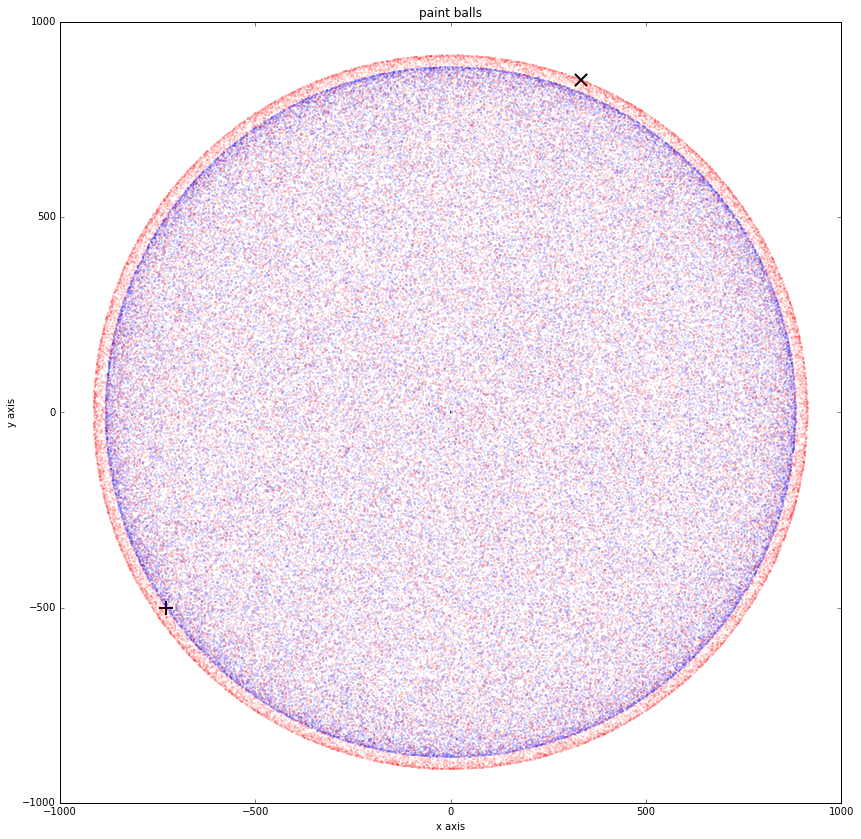

In [30]:
## This cell fires one million photons at the droplet nC (number-of-colors) times and tracks where they come out

# From here on let's use a random number generator to determine each photon's incident location in a plane
#   perpendicular to the sun-droplet axis. This coordinate (x, y) in this plane will be uniformly distributed
#   in x and y. The radial distance from the origin to (x, y) is a radial coordinate r. The azimuthal angle about
#   the sun-droplet axis will be called theta. Looking sideways at the droplet (as above) so that the light is
#   arriving from the right we have a scattering angle relative to the sun-droplet axis.

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(14,14))
ax.add_patch(plt.Circle((0, 0), 1, color = 'k', fill=False)) 
radiusCircleAtInf = 200.0
ax.axis('equal')
ax.set(xlim=(-1000., 1000.), ylim=(-1000.,1000.))
ax.set(xlabel='x axis', ylabel = 'y axis', title='paint balls')

# This places an x and a + along the red and blue peripheries
ax.scatter(333,850,s=150,c='k',marker='x',lw=2)
ax.scatter(-730,-500,s=200,c='k',marker='+',lw=2)

# Value chosen to highlight the peripheral concentration without washing out the rest of the disk
nPhotonsPerColor = 100000
wall = 1000.0

# loop index i over all colors of interest ('ROYGBIV')
useOnlyTheseColorIndices = [1, 6]
for i in range(nC):
    if i in useOnlyTheseColorIndices:
        wavelength = cWaves[i]

        # indices of refraction
        iorWater = indexOfRefractionForWater(wavelength)
        iorAir = indAir = 1.00029

        xDot = []
        yDot = []

        for j in range(nPhotonsPerColor):
            x = 2.0*np.random.rand() - 1.0
            y = 2.0*np.random.rand() - 1.0
            r = np.sqrt(x*x + y*y)
            if r < 1.0:
                thetaEject = np.arctan2(y, x) + pi
                scatterAngle = scatter(r, wavelength, iorAir, iorWater)
                leadFactor = wall * np.tan(scatterAngle)
                xDot.append(leadFactor * np.cos(thetaEject))
                yDot.append(leadFactor * np.sin(thetaEject))

        # Note use of 'lw' to set linewidth to zero so there is no outline around the markers
        # Also 's' sets the size of the marker in some sort of font-related units. 0.5 is tiny.
        ax.scatter(xDot, yDot, s=.5, c=cLabels[i], marker='o', lw=0)

__Caption__ This paint board shows the impacts of many photons. Only a selection of colors is used; using too many winds up muddying up the results. Clearly apparent are the concentrations of blue and red dots at the respective perimeters. These are all photons back-scattered by a single droplet. In the interior of the circles the dots are uniformly distributed and this would be interpreted by our eye (averaging across the spectrum) as white light. Imagine standing in front of this paint board and moving about, always keeping your gaze on the droplet opposite you. In most locations the droplet would appear white... but if your eye were located at the x the droplet would appear blue; and if your eye were located at the + the droplet would appear red.

## Part 7. The eye of the beholder

Finally (!) let's consider the cumulative effect of many droplets. In the previous step we threw a lot of photons at one droplet and marked where they went. This time we throw many photons at many droplets and create a visual based on a single viewing perspective. This simulates seeing a rainbow as backscattered light. 

## Conclusion

Snell's law combined with the wavelength dependency of the index of refraction in water (dispersion) gives a preferential scattering angle that varies across a litte more than one degree with color. This is the apparent width of the color band as many droplets conspire together to make pointillistic contributions to what we perceive as a rainbow. 

This correspondence to pointillism is one of three delightful realizations to come from this analysis beyond its support for the claim that rainbows exist. The second realization is that the _bow_ shape is really the arc of a circle; so one might search for such circles perhaps by looking for rain clouds opposite the sun from high narrow vantage points; spires of rock or tall buildings or airplanes. (Izzie saw the third quadrant the other day as her plane took off.) Thirdly each water droplet contributes to many preferential scatterings in many directions, producing a cone of rainbow-colored light whose axis goes through the sun, so that in consequence each perceived rainbow is unique to the person who sees it. Seeing the rainbow across the bow requires a row of droplets; and so on all around the arc.